In [1]:
import scanpy as sc
import surgeon
sc.settings.set_figure_params(dpi=200, frameon=False)

Using TensorFlow backend.


In [10]:
condition_key = "batch"
cell_type_key = 'cell.type'
target_condition = "1"

# Loading mouse lung atlas datasets and data preparation

In [3]:
adata = sc.read("./data/lung_atlas/lung_atlas.h5ad")
adata

AnnData object with n_obs × n_vars = 36373 × 15151 
    obs: 'batch', 'cell.type'

In [4]:
adata.obs[condition_key].value_counts()

0    26013
1    10360
Name: batch, dtype: int64

#### normalizatiom and  Extracting HVGs 

In [5]:
adata = surgeon.utils.normalize(adata, 
                                filter_min_counts=False,
                                normalize_input=False,
                                logtrans_input=True, 
                                size_factors=True,
                                n_top_genes=2000)

In [6]:
adata

AnnData object with n_obs × n_vars = 36373 × 2000 
    obs: 'batch', 'cell.type', 'n_counts', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

## Number of cells in each batch

In [7]:
adata.obs[condition_key].value_counts()

0    26013
1    10360
Name: batch, dtype: int64

## visualization  of the original data

In [20]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/mohammad/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


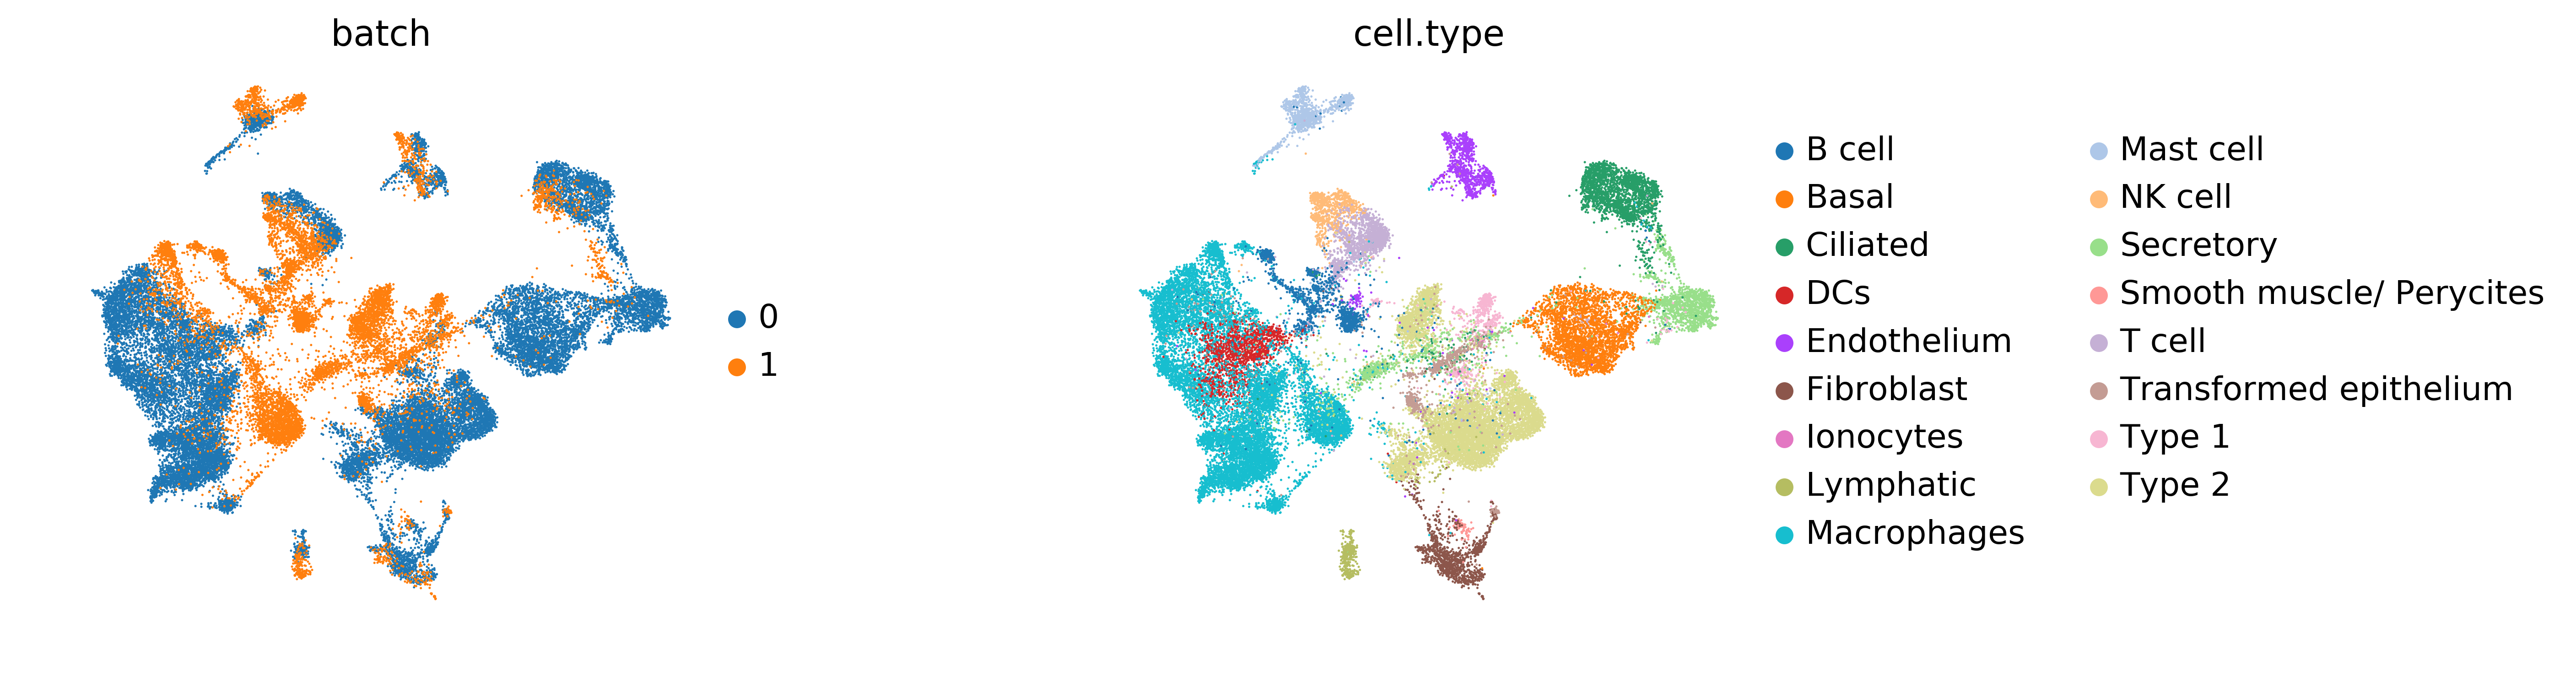

In [21]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], wspace=0.5)

## Now we leave out one study  (10X_v3) for training the newtork

In [11]:
adata_for_training = adata[adata.obs[condition_key] != target_condition]
adata_for_training

View of AnnData object with n_obs × n_vars = 26013 × 2000 
    obs: 'batch', 'cell.type', 'n_counts', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

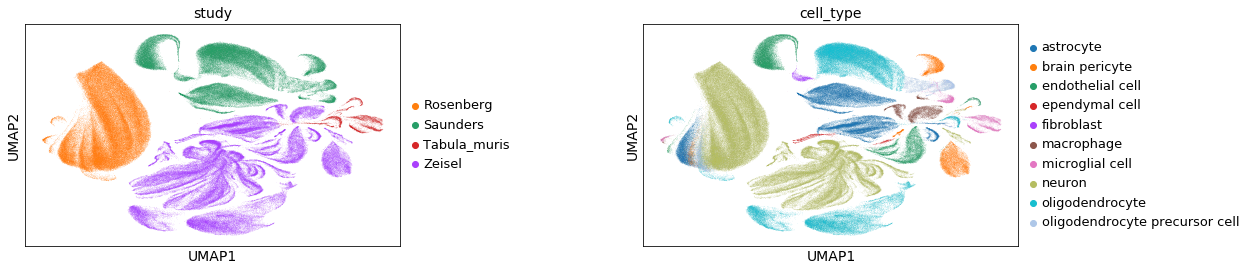

In [23]:
sc.pl.umap(adata_for_training, color=[condition_key, cell_type_key], wspace=0.5)

In [12]:
adata_out_of_sample = adata[adata.obs[condition_key] == target_condition]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 10360 × 2000 
    obs: 'batch', 'cell.type', 'n_counts', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

## Train/Test Split

In [13]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.85)

In [14]:
train_adata.shape, valid_adata.shape

((22111, 2000), (3902, 2000))

In [15]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [17]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=20,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.001,
                             scale_factor=1.0,
                             clip_value=5.0,
                             loss_fn='nb',
                             model_path="./models/CVAE/before-lung/",
                             dropout_rate=0.2,
                             output_activation='relu')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2001)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1024512     concatenate_3[0][0]              
__________

## We assign each study to a numerical label 

In [18]:
train_adata.obs[condition_key].value_counts()

0    22111
Name: batch, dtype: int64

In [19]:
condition_encoder = {'0': 0, '1': 1}

## Training the network

In [21]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              cell_type_key=cell_type_key,
              le=condition_encoder, 
              n_epochs=1000,
              batch_size=32, 
              early_stop_limit=30,
              lr_reducer=20, 
              n_per_epoch=0,
              save=True, 
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 22111 samples, validate on 3902 samples
Epoch 1/1000
 - 7s - loss: 0.1943 - nb: 0.1943 - val_loss: 0.1735 - val_nb: 0.1735
Epoch 2/1000
 - 4s - loss: 0.1762 - nb: 0.1762 - val_loss: 0.1703 - val_nb: 0.1703
Epoch 3/1000
 - 4s - loss: 0.1734 - nb: 0.1734 - val_loss: 0.1689 - val_nb: 0.1689
Epoch 4/1000
 - 5s - loss: 0.1719 - nb: 0.1719 - val_loss: 0.1676 - val_nb: 0.1676
Epoch 5/1000
 - 4s - loss: 0.1711 - nb: 0.1711 - val_loss: 0.1672 - val_nb: 0.1672
Epoch 6/1000
 - 4s - loss: 0.1704 - nb: 0.1704 - val_loss: 0.1669 - val_nb: 0.1669
Epoch 7/1000
 - 4s - loss: 0.1700 - nb: 0.1700 - val_loss: 0.1667 - val_nb: 0.1667
Epoch 8/1000
 - 4s - loss: 0.1696 - nb: 0.1696 - val_loss: 0.1665 - val_nb: 0.1665
Epoch 9/1000
 - 4s - loss: 0.1692 - nb: 0.1692 - val_loss: 0.1662 - val_nb: 0.1662
Epoch 10/1000
 - 4s - loss: 0.1690 - nb: 0.1690 - val_loss: 0.1660 - val_nb: 0.1660
Epoch 11/1000
 - 4s - loss: 0.1688 - nb: 0.1688 - val_loss: 0.1659 - val

In [22]:
network.condition_encoder

{'0': 0, '1': 1}

In [23]:
encoder_labels, _ = surgeon.utils.label_encoder(
    adata_for_training, label_encoder=network.condition_encoder, condition_key=condition_key)

In [24]:
latent_adata = network.to_latent(adata_for_training, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 26013 × 20 
    obs: 'batch', 'cell.type', 'n_counts', 'size_factors'

In [25]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

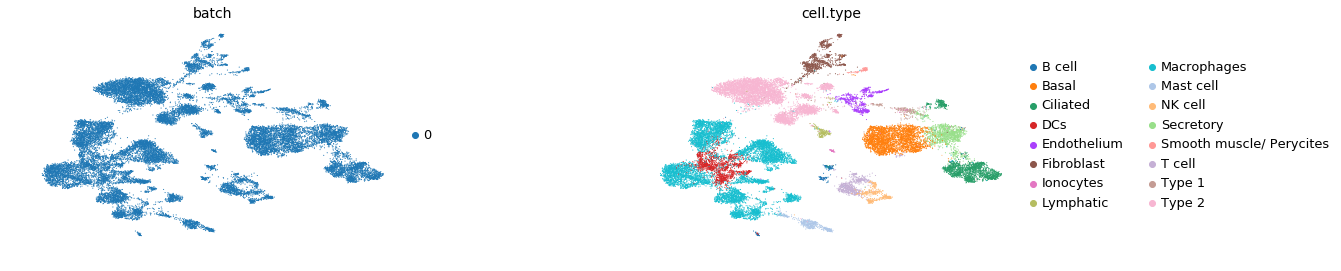

In [26]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

# Perfroming architecture Surgery

In [30]:
new_network = surgeon.operate(network, 
                              new_conditions=target_condition,
                              init='Xavier', 
                              freeze=True)

/home/mohsen/scnet/surgeon/models/_cvae.py:149: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 2)            0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 2002)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1025024     concatenate_5[0][0]              
__________

In [31]:
new_network.condition_encoder

{'0': 0, '1': 1}

## Train with small new dataset containing out-of-sample condition

In [32]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.85)

In [33]:
train_adata.shape, valid_adata.shape

((8806, 2000), (1554, 2000))

In [34]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  cell_type_key=cell_type_key,
                  le=new_network.condition_encoder, 
                  n_epochs=300,
                  batch_size=32, 
                  early_stop_limit=40,
                  lr_reducer=30,
                  n_per_epoch=0,
                  save=True, 
                  verbose=2)

Train on 8806 samples, validate on 1554 samples
Epoch 1/300
 - 3s - loss: 0.1824 - nb: 0.1824 - val_loss: 0.1688 - val_nb: 0.1688
Epoch 2/300
 - 1s - loss: 0.1775 - nb: 0.1775 - val_loss: 0.1658 - val_nb: 0.1658
Epoch 3/300
 - 1s - loss: 0.1749 - nb: 0.1749 - val_loss: 0.1649 - val_nb: 0.1649
Epoch 4/300
 - 1s - loss: 0.1737 - nb: 0.1737 - val_loss: 0.1643 - val_nb: 0.1643
Epoch 5/300
 - 1s - loss: 0.1729 - nb: 0.1729 - val_loss: 0.1642 - val_nb: 0.1642
Epoch 6/300
 - 1s - loss: 0.1723 - nb: 0.1723 - val_loss: 0.1633 - val_nb: 0.1633
Epoch 7/300
 - 1s - loss: 0.1719 - nb: 0.1719 - val_loss: 0.1635 - val_nb: 0.1635
Epoch 8/300
 - 1s - loss: 0.1715 - nb: 0.1715 - val_loss: 0.1627 - val_nb: 0.1627
Epoch 9/300
 - 1s - loss: 0.1713 - nb: 0.1713 - val_loss: 0.1622 - val_nb: 0.1622
Epoch 10/300
 - 1s - loss: 0.1710 - nb: 0.1710 - val_loss: 0.1625 - val_nb: 0.1625
Epoch 11/300
 - 1s - loss: 0.1708 - nb: 0.1708 - val_loss: 0.1623 - val_nb: 0.1623
Epoch 12/300
 - 1s - loss: 0.1706 - nb: 0.1706 -

## Projecting all data in to the latent space of the model 

In [35]:
encoder_labels, _ = surgeon.utils.label_encoder(adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [36]:
adata.obs[condition_key].value_counts()

0    26013
1    10360
Name: batch, dtype: int64

In [37]:
latent_adata = new_network.to_latent(adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 36373 × 20 
    obs: 'batch', 'cell.type', 'n_counts', 'size_factors'

In [38]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

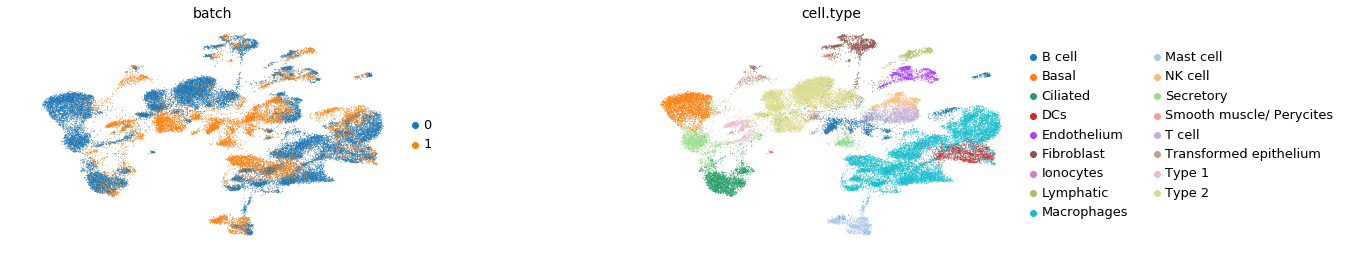

In [39]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)